In [1]:
import pandas as pd
from pathlib import Path
import os
import random 
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

In [2]:
path = Path('data')

In [3]:
metadata = pd.read_csv(path / 'metadata_fTq0l2T.csv')
metadata

,tile_id,filename,md5_hash,filesize_bytes,type,in_train
0,JW725114,JW725114_satellite.tif,97b19f0747260df89e23f33caced3632,1105392,satellite,True
1,UX493605,UX493605_satellite.tif,fbdd888f115ede68ee83996071c007dc,1270901,satellite,True
2,OU500661,OU500661_satellite.tif,2003e7d0eaf10894e796721b5d344eeb,1238008,satellite,True
3,DC227980,DC227980_satellite.tif,8498ccaff72b8d7cfcc7f9404baf36f2,1252483,satellite,True
4,SS602790,SS602790_satellite.tif,525618743f94a065158f432bd5ee2d32,1535964,satellite,True
...,...,...,...,...,...,...
12691,CW974988,CW974988_kelp.tif,72bad993b1a6fede6acfea561da9ff22,2545,kelp,False
12692,VQ623772,VQ623772_kelp.tif,72bad993b1a6fede6acfea561da9ff22,2545,kelp,False
12693,LX380049,LX380049_kelp.tif,72bad993b1a6fede6acfea561da9ff22,2545,kelp,False
12694,OY863116,OY863116_kelp.tif,72bad993b1a6fede6acfea561da9ff22,2545,kelp,False


The fields in metadata.csv are:

- tile_id (str): A unique identifier for a single patch of coastal water
- filename (str): The filename of the corresponding image, which follows the naming convention {tile_id}_satellite.tif for an input satellite image or {tile_id}_kelp.tif for the binary kelp mask
- md5_hash (str): The md5 hash value to make sure the data was transmitted correctly
- filesize_bytes (int): The size of the file in bytes
- type (str): Whether the GeoTIFF is a satellite or kelp image
- in_train (bool): TRUE if the image is a part of the training data or FALSE if it is in the test data

In [4]:
train_images = os.listdir(path / 'train_satellite')
len(train_images)

5635

In [5]:
image_ids = [image.split('_')[0] for image in train_images]
train_masks = [image + '_kelp.tif' for image in image_ids]
len(train_masks)

5635

In [6]:
_masks = os.listdir(path / 'train_kelp')
for mask in train_masks:
	assert mask in _masks

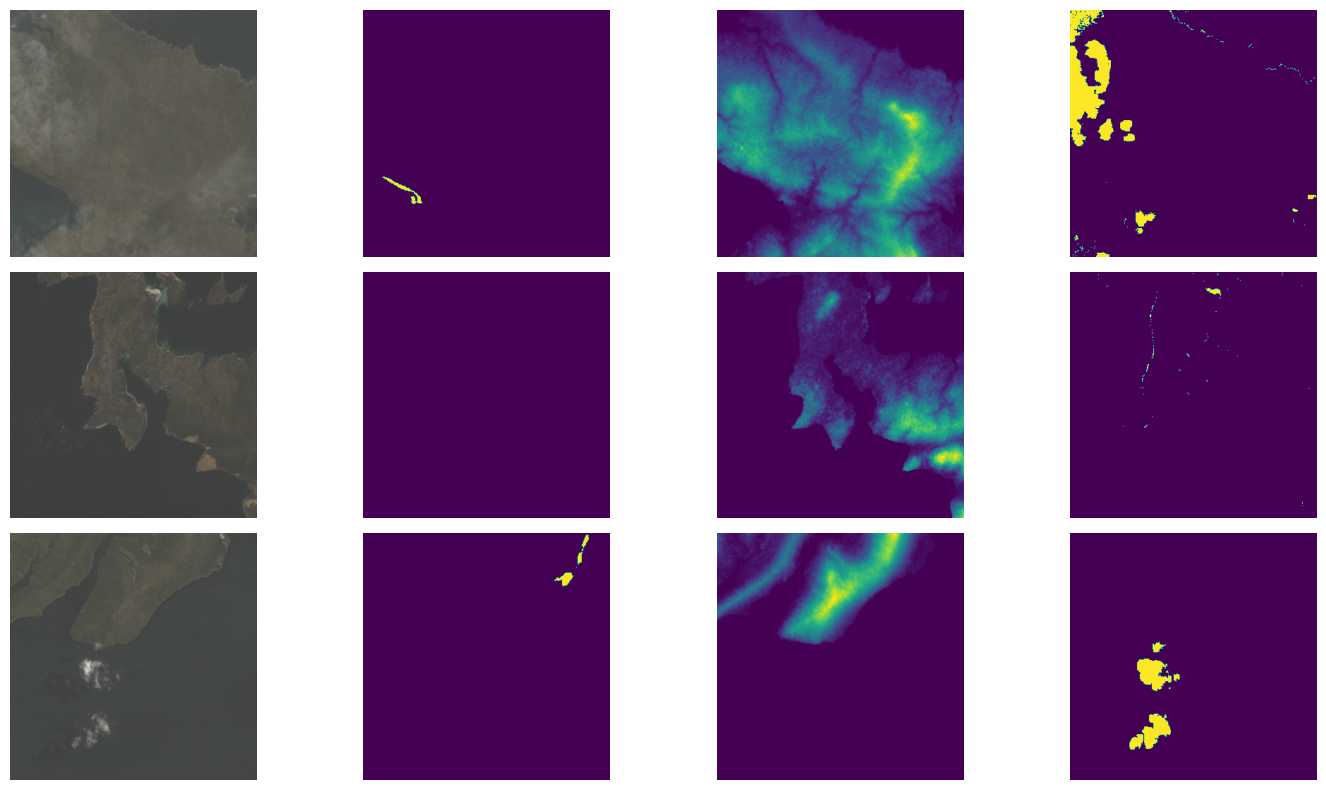

In [14]:
rows, cols = 3, 4 
fig, axs = plt.subplots(rows, cols, figsize=(15, 8))
for row in range(rows):
	image_id = random.choice(image_ids)
	image_name = image_id + '_satellite.tif'
	image = io.imread(path / 'train_satellite' / image_name)
	# print(image.shape)
	rgb = image[..., 2:5] # swir1, nir, r, g, b, clouds, dem
	ax = plt.subplot(rows, cols, row * cols + 1)
	rgb_norm = np.clip(rgb / 3e4, 0, 1)
	ax.imshow(rgb_norm)
	ax.axis('off')
	mask_name = image_id + '_kelp.tif'
	mask = io.imread(path / 'train_kelp' / mask_name)
	ax = plt.subplot(rows, cols, row * cols + 2)
	ax.imshow(mask)
	ax.axis('off')
	dem = image[..., 6]
	ax = plt.subplot(rows, cols, row * cols + 3)
	ax.imshow(dem)
	ax.axis('off')
	clouds = image[..., 5]
	ax = plt.subplot(rows, cols, row * cols + 4)
	ax.imshow(clouds)
	ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
dem.max(), dem.min(), clouds.max(), clouds.min()

(286, 0, 1, 0)

The first five bands of each tile are spectral bands extracted from the Level 2 Landsat product. These are observations of surface reflectance, i.e., the fraction of incoming solar radiation that is reflected from Earth's surface, after adjusting for atmospheric and geometric effects. The provided spectra include shortwave infrared (SWIR1), near-infrared (NIR), red, green, and blue bands obtained using Landsat satellites 5, 7, and 8. Together, these bands capture a broad spectrum of electromagnetic radiation and have been selected for their usefulness for monitoring coastal environments.

Surface reflectance values have been re-scaled to 16-bit integers (so-called digital numbers) to optimize computational efficiency. Valid values are positive integers in the range from 0 to 65,536, with the integer -32,768 indicating a missing value. Specific information about the band wavelengths can be found in this USGS resource.

TIP: Competitors are not required to account for wavelength differences between sensors, as these corrections are already undertaken during USGS data processing. However, it has been demonstrated in previous modeling efforts that value normalization can be beneficial. We encourage solvers to explore various preprocessing methods for experimentation.

The remaining two bands can be used to exclude irrelevant pixels. The sixth band is a Digital Elevation Model (DEM) containing elevation measured in meters from sea-level derived from Advanced Spaceborne Thermal Emission and Reflection Radiometer (ASTER) data, which can be utilized to generate a land mask. The seventh and final band is a cloud mask indicating the presence (1) or absence (0) of clouds.

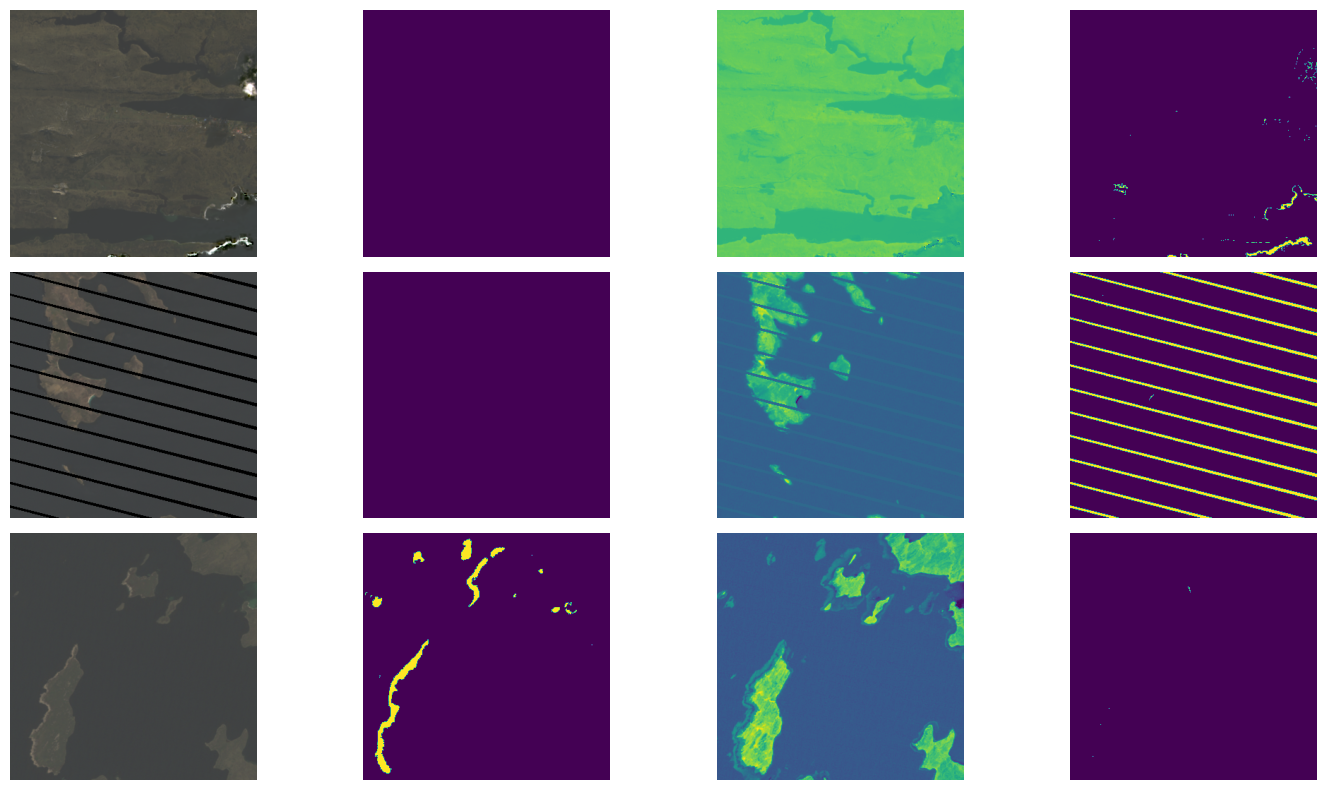

In [96]:
# some indices

rows, cols = 3, 4 
fig, axs = plt.subplots(rows, cols, figsize=(15, 8))
for row in range(rows):
	image_id = random.choice(image_ids)
	image_name = image_id + '_satellite.tif'
	image = io.imread(path / 'train_satellite' / image_name)
	# print(image.shape)
	rgb = image[..., 2:5] # swir1, nir, r, g, b, clouds, dem
	ax = plt.subplot(rows, cols, row * cols + 1)
	rgb_norm = np.clip(rgb / 3e4, 0, 1)
	ax.imshow(rgb_norm)
	ax.axis('off')
	mask_name = image_id + '_kelp.tif'
	mask = io.imread(path / 'train_kelp' / mask_name)
	ax = plt.subplot(rows, cols, row * cols + 2)
	ax.imshow(mask)
	ax.axis('off')
	nir, red = image[..., 1], rgb[..., 1]
	ndvi = (nir - red) / (nir + red)
	ax = plt.subplot(rows, cols, row * cols + 3)
	ax.imshow(ndvi)
	ax.axis('off')
	clouds = image[..., 5]
	ax = plt.subplot(rows, cols, row * cols + 4)
	ax.imshow(clouds)
	ax.axis('off')
plt.tight_layout()
plt.show()